In [1]:
#error message 제거
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [2]:
IMAGE_PATH = '/home/jwjang/final_final_data'

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import pathlib
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.models import Model,Sequential

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.9.12
Tensorflow version: 2.8.0
Keras version: 2.8.0


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

train_generator = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'training'
)

valid_generator = datagen.flow_from_directory(
    IMAGE_PATH,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

Found 35254 images belonging to 10 classes.
Found 8810 images belonging to 10 classes.


In [5]:
image_batch, label_batch = next(valid_generator)
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 10))

In [6]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('can_labels.txt', 'w') as f:
  f.write(labels)

{'2%_peach': 0, 'chilsung_cider': 1, 'coca_cola': 2, 'demisoda': 3, 'fanta_orange': 4, 'gatorade': 5, 'pepsi': 6, 'pocari_sweat': 7, 'powerade': 8, 'welchs_grape': 9}


In [7]:
#build the Resnet model 
resnet = ResNet50(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False)  

In [8]:
# let's train our Model 
inputs = resnet.input
# add an average pooling layer
x = resnet.output
x = GlobalAveragePooling2D()(x)
#first dense layer
x = Dense(512, activation='relu')(x)
#dropout 
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# output layer
outputs = Dense(10, activation ='softmax')(x)
# this is the model we will train
model = Model(inputs=inputs, outputs=outputs)

In [9]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=100,
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator))

Epoch 1/100


2022-11-05 02:46:09.069059: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-05 02:46:09.069093: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-05 02:46:09.099410: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-05 02:46:09.099427: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

1102/1102 [==============================] - 371s 332ms/step - loss: 0.3615 - accuracy: 0.9010 - val_loss: 0.1850 - val_accuracy: 0.9363
Epoch 2/100
1102/1102 [==============================] - 364s 331ms/step - loss: 0.2339 - accuracy: 0.9354 - val_loss: 0.1508 - val_accuracy: 0.9477
Epoch 3/100
1102/1102 [==============================] - 364s 331ms/step - loss: 0.1241 - accuracy: 0.9659 - val_loss: 0.0445 - val_accuracy: 0.9866
Epoch 4/100
1102/1102 [==============================] - 364s 331ms/step - loss: 0.0656 - accuracy: 0.9812 - val_loss: 0.0415 - val_accuracy: 0.9872
Epoch 5/100
1102/1102 [==============================] - 364s 330ms/step - loss: 0.1102 - accuracy: 0.9722 - val_loss: 0.0501 - val_accuracy: 0.9857
Epoch 6/100
1102/1102 [==============================] - 364s 331ms/step - loss: 0.0590 - accuracy: 0.9852 - val_loss: 0.0525 - val_accuracy: 0.9808
Epoch 7/100
1102/1102 [==============================] - 364s 330ms/step - loss: 0.0440 - accuracy: 0.9883 - val_loss:

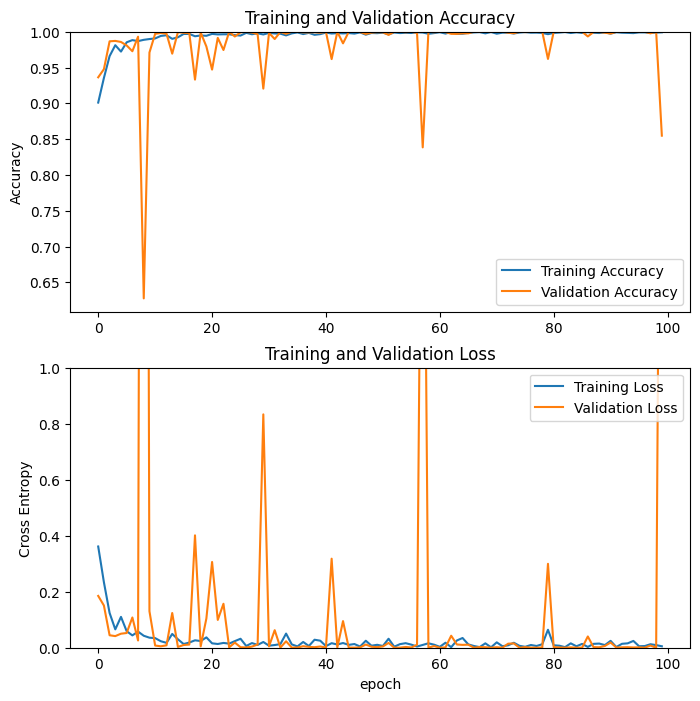

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('resnet50_1104_2330.tflite', 'wb') as f:
  f.write(tflite_model)

2022-11-05 12:53:34.051362: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpc8hhmhwq/assets


2022-11-05 12:53:50.442420: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-11-05 12:53:50.442461: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
